# SYCL Introduction

We use a simple Mandelbrot implementation that can either be compiled for the USM or the Buffered Memory Model.

In [ ]:
%%file mandelbrot.cpp

#include <chrono>
#include <iomanip>
#include <iostream>
#include <complex>
#include <exception>
#include <iomanip>
#include <iostream>
#include "dpc_common.hpp"

#define STB_IMAGE_IMPLEMENTATION
#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"

using namespace std;
using namespace sycl;

constexpr int row_size = 512;
constexpr int col_size = 512;
constexpr int max_iterations = 100;
constexpr int repetitions = 100;

// Parameters used in Mandelbrot including number of row, column, and iteration.
struct MandelParameters {
    int row_count_;
    int col_count_;
    int max_iterations_;

    typedef std::complex<float> ComplexF;
    static std::complex<float> complex_square( std::complex<float> c)
    {
        return std::complex<float>( c.real()*c.real() - c.imag()*c.imag(), c.real()*c.imag()*2 );
    }

    MandelParameters(int row_count, int col_count, int max_iterations)
        : row_count_(row_count),
        col_count_(col_count),
        max_iterations_(max_iterations) {}

    int row_count() const { return row_count_; }
    int col_count() const { return col_count_; }
    int max_iterations() const { return max_iterations_; }

    // Scale from 0..row_count to -1.5..0.5
    float ScaleRow(int i) const { return -1.5f + (i * (2.0f / row_count_)); }

    // Scale from 0..col_count to -1..1
    float ScaleCol(int i) const { return -1.0f + (i * (2.0f / col_count_)); }

    // Mandelbrot set are points that do not diverge within max_iterations.
    int Point(const ComplexF &c) const {
        int count = 0;
        ComplexF z = 0;

        for (int i = 0; i < max_iterations_; ++i) {
            auto r = z.real();
            auto im = z.imag();

            // Leave loop if diverging.
            if (((r * r) + (im * im)) >= 4.0f) {
                break;
            }

            // z = z * z + c;
            z = complex_square(z) + c;
            count++;
        }

        return count;
    }
};

// Shared functions for computing Mandelbrot set.
class Mandel {
    private:
        MandelParameters p_;

    protected:
        int *data_;

    public:
        Mandel(int row_count, int col_count, int max_iterations)
            : p_(row_count, col_count, max_iterations) {
                data_ = nullptr;
            }

        virtual ~Mandel() {}
        virtual void Alloc() { data_ = new int[p_.row_count() * p_.col_count()]; }
        virtual void Free() { delete[] data_; }

        MandelParameters GetParameters() const { return p_; }

        void WriteImage() {
            constexpr int channel_num{3};
            int row_count = p_.row_count();
            int col_count = p_.col_count();

            uint8_t *pixels = new uint8_t[col_count * row_count * channel_num];

            int index = 0;

            for (int j = 0; j < row_count; ++j) {
                for (int i = 0; i < col_count; ++i) {
                    float normalized = (1.0 * data_[i * col_count + j]) / max_iterations;
                    int color = int(normalized * 0xFFFFFF);  // 16M color.

                    int r = (color >> 16) & 0xFF;
                    int g = (color >> 8) & 0xFF;
                    int b = color & 0xFF;

                    pixels[index++] = r;
                    pixels[index++] = g;
                    pixels[index++] = b;
                }
            }

            stbi_write_png("mandelbrot.png", row_count, col_count, channel_num, pixels,
                    col_count * channel_num);

            delete[] pixels;
        }

        // Use only for debugging with small dimensions.
        void Print() {
            if (p_.row_count() > 128 || p_.col_count() > 128) {
                cout << " Rendered image output to file: mandelbrot.png "
                    "(output too large to display in text)\n";

                return;
            }

            for (int i = 0; i < p_.row_count(); ++i) {
                for (int j = 0; j < p_.col_count_; ++j) {
                    cout << std::setw(1)
                        << ((GetValue(i, j) >= p_.max_iterations()) ? "x" : " ");
                }

                cout << "\n";
            }
        }

        // Accessor for data and count values.
        int *data() const { return data_; }

        // Accessor to read a value from the mandelbrot data matrix.
        int GetValue(int i, int j) const { return data_[i * p_.col_count_ + j]; }

        // Mutator to store a value into the mandelbrot data matrix.
        void SetValue(int i, int j, float v) { data_[i * p_.col_count_ + j] = v; }

        // Validate the results match.
        void Verify(Mandel &m) {
            if ((m.p_.row_count() != p_.row_count_) ||
                    (m.p_.col_count() != p_.col_count_)) {
                cout << "Fail verification - matrix size is different\n";
                throw std::runtime_error("Verification failure");
            }

            int diff = 0;

            for (int i = 0; i < p_.row_count(); ++i) {
                for (int j = 0; j < p_.col_count(); ++j) {
                    if (m.GetValue(i, j) != GetValue(i, j)) diff++;
                }
            }

            double tolerance = 0.05;
            double ratio = (double)diff / (double)(p_.row_count() * p_.col_count());

#if _DEBUG
            cout << "diff: " << diff << "\n";
            cout << "total count: " << p_.row_count() * p_.col_count() << "\n";
#endif

            if (ratio > tolerance) {
                cout << "Fail verification - diff larger than tolerance\n";
                throw std::runtime_error("Verification failure");
            }

#if _DEBUG
            cout << "Pass verification\n";
#endif
        }
};

// Serial implementation for computing Mandelbrot set.
class MandelSerial : public Mandel {
    public:
        MandelSerial(int row_count, int col_count, int max_iterations)
            : Mandel(row_count, col_count, max_iterations) {
                Alloc();
            }

        ~MandelSerial() { Free(); }

        void Evaluate() {
            // Iterate over image and compute mandel for each point.
            MandelParameters p = GetParameters();

            for (int i = 0; i < p.row_count(); ++i) {
                for (int j = 0; j < p.col_count(); ++j) {
                    auto c = MandelParameters::ComplexF(p.ScaleRow(i), p.ScaleCol(j));
                    SetValue(i, j, p.Point(c));
                }
            }
        }
};

// Parallel implementation for computing Mandelbrot set using buffers.
class MandelParallel : public Mandel {
    public:
        MandelParallel(int row_count, int col_count, int max_iterations)
            : Mandel(row_count, col_count, max_iterations) {
                Alloc();
            }

        ~MandelParallel() { Free(); }

        void Evaluate(queue &q) {
            // Iterate over image and check if each point is in Mandelbrot set.
            MandelParameters p = GetParameters();

            const int rows = p.row_count();
            const int cols = p.col_count();

            buffer data_buf(data(), range(rows, cols));

            // We submit a command group to the queue.
            q.submit([&](handler &h) {
                    // Get access to the buffer.
                    auto b = data_buf.get_access(h,write_only);

                    // Iterate over image and compute mandel for each point.
                    h.parallel_for(range<2>(rows, cols), [=](auto index) {
                            int i = int(index[0]);
                            int j = int(index[1]);
                            auto c = MandelParameters::ComplexF(p.ScaleRow(i), p.ScaleCol(j));
                            b[index] = p.Point(c);
                            });
                    });
        }
};

// Parallel implementation for computing Mandelbrot set using Unified Shared
// Memory (USM).
class MandelParallelUsm : public Mandel {
    private:
        queue *q;

    public:
        MandelParallelUsm(int row_count, int col_count, int max_iterations, queue *q)
            : Mandel(row_count, col_count, max_iterations) {
                this->q = q;
                Alloc();
            }

        ~MandelParallelUsm() { Free(); }

        virtual void Alloc() {
            MandelParameters p = GetParameters();
            data_ = malloc_shared<int>(p.row_count() * p.col_count(), *q);
        }

        virtual void Free() { free(data_, *q); }

        void Evaluate(queue &q) {
            // Iterate over image and check if each point is in Mandelbrot set.
            MandelParameters p = GetParameters();

            const int rows = p.row_count();
            const int cols = p.col_count();
            auto ldata = data_;

            // Iterate over image and compute mandel for each point.
            auto e = q.parallel_for(range(rows * cols), [=](id<1> index) {
                    int i = index / cols;
                    int j = index % cols;
                    auto c = MandelParameters::ComplexF(p.ScaleRow(i), p.ScaleCol(j));
                    ldata[index] = p.Point(c);
                    });

            // Wait for the asynchronous computation on device to complete.
            e.wait();
        }
};

using namespace std;
using namespace sycl;

void ShowDevice(queue &q) {
    // Output platform and device information.
    auto device = q.get_device();
    auto p_name = device.get_platform().get_info<info::platform::name>();
    cout << std::setw(20) << "Platform Name: " << p_name << "\n";
    auto p_version = device.get_platform().get_info<info::platform::version>();
    cout << std::setw(20) << "Platform Version: " << p_version << "\n";
    auto d_name = device.get_info<info::device::name>();
    cout << std::setw(20) << "Device Name: " << d_name << "\n";
    auto max_work_group = device.get_info<info::device::max_work_group_size>();
    cout << std::setw(20) << "Max Work Group: " << max_work_group << "\n";
    auto max_compute_units = device.get_info<info::device::max_compute_units>();
    cout << std::setw(20) << "Max Compute Units: " << max_compute_units << "\n\n";
}

void Execute(queue &q) {
    // Demonstrate the Mandelbrot calculation serial and parallel.
#ifdef MANDELBROT_USM
    cout << "Parallel Mandelbrot set using USM.\n";
    MandelParallelUsm m_par(row_size, col_size, max_iterations, &q);
#else
    cout << "Parallel Mandelbrot set using buffers.\n";
    MandelParallel m_par(row_size, col_size, max_iterations);
#endif

    MandelSerial m_ser(row_size, col_size, max_iterations);

    // Run the code once to trigger JIT.
    m_par.Evaluate(q);

    // Run the parallel version and time it.
    dpc_common::TimeInterval t_par;
    for (int i = 0; i < repetitions; ++i) m_par.Evaluate(q);
    double parallel_time = t_par.Elapsed();

    // Print the results.
    m_par.Print();
    m_par.WriteImage();

    // Run the serial version.
    dpc_common::TimeInterval t_ser;
    m_ser.Evaluate();
    double serial_time = t_ser.Elapsed();

    // Report the results.
    cout << std::setw(20) << "Serial time: " << serial_time << "s\n";
    cout << std::setw(20) << "Parallel time: " << (parallel_time / repetitions)
        << "s\n";

    // Validate.
    m_par.Verify(m_ser);
}

int main(int argc, char *argv[]) {
    try {
        // Create a queue on the default device. Set SYCL_DEVICE_TYPE environment
        // variable to (CPU|GPU|FPGA|HOST) to change the device.
        queue q(default_selector_v);

        // Display the device info.
        ShowDevice(q);

        // Compute Mandelbrot set.
        Execute(q);
    } catch (...) {
        // Some other exception detected.
        cout << "Failed to compute Mandelbrot set.\n";
        std::terminate();
    }

    cout << "Successfully computed Mandelbrot set.\n";
    return 0;
}

## 1. Compile for CPU and NVIDIA GPU target

In [ ]:
%%file mandelbrot_compile.sh
#!/bin/bash

#SBATCH --job-name    compile_mandelbrot
#SBATCH --cluster     vsc5
#SBATCH --reservation training_gpu
#SBATCH --qos         zen3_0512_a100x2_training
#SBATCH --partition   zen3_0512_a100x2
#SBATCH --gres        gpu:1
#SBATCH --time        00:01:00

###########################

spack unload
spack load cuda@11.8.0

source /opt/sw/vsc4/VSC/x86_64/generic/intel/oneapi/setvars.sh 
export LD_LIBRARY_PATH=/gpfs/opt/sw/cuda-zen/spack-0.19.0/opt/spack/linux-almalinux8-zen/gcc-9.5.0/gcc-12.2.0-nu5le4qn6edhcjiocq7wddclrvdj4xfg/lib64:$LD_LIBRARY_PATH    

###########################

echo "**********************************************"
echo "output of nvidia-smi"
echo "**********************************************"
nvidia-smi


echo "**********************************************"
echo "output of sycl-ls"
echo "**********************************************"
sycl-ls


echo "**********************************************"
echo "compiling "
echo "icpx -fsycl -fsycl-targets=nvptx64-nvidia-cuda,spir64_x86_64 mandelbrot.cpp -o mandelbrot"
echo "**********************************************"
icpx -fsycl -fsycl-targets=nvptx64-nvidia-cuda,spir64_x86_64 mandelbrot.cpp -o mandelbrot


In [ ]:
! sbatch mandelbrot_compile.sh

In [ ]:
! squeue -u $USER --cluster vsc5

## 2. Run on NVIDIA GPU

In [ ]:
%%file mandelbrot_gpu_run.sh
#!/bin/bash

#SBATCH --job-name    run_mandelbrot_gpu
#SBATCH --cluster     vsc5
#SBATCH --reservation training_gpu
#SBATCH --qos         zen3_0512_a100x2_training
#SBATCH --partition   zen3_0512_a100x2
#SBATCH --gres        gpu:1
#SBATCH --time        00:01:00

###########################

spack unload
spack load cuda@11.8.0

source /opt/sw/vsc4/VSC/x86_64/generic/intel/oneapi/setvars.sh 
export LD_LIBRARY_PATH=/gpfs/opt/sw/cuda-zen/spack-0.19.0/opt/spack/linux-almalinux8-zen/gcc-9.5.0/gcc-12.2.0-nu5le4qn6edhcjiocq7wddclrvdj4xfg/lib64:$LD_LIBRARY_PATH    

###########################

echo "starting program mandelbrot on the NVIDIA GPU"
echo "**********************************************"
./mandelbrot
echo "**********************************************"


In [ ]:
!sbatch mandelbrot_gpu_run.sh

In [ ]:
!squeue -u $USER

After a while you should see `mandelbrot.png` to appear:\
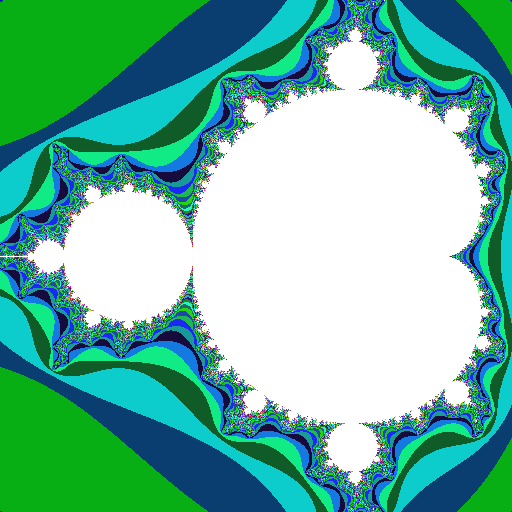

## 3. Run on the CPU

In [ ]:
%%file mandelbrot_cpu_run.sh
#!/bin/bash

#SBATCH --job-name    run_mandelbrot_cpu
#SBATCH --cluster     vsc5
#SBATCH --reservation training_cpu
#SBATCH --nodes       1
#SBATCH --qos         zen3_0512
#SBATCH --partition   zen3_0512
#SBATCH --time        00:01:00

###########################

source /opt/sw/vsc4/VSC/x86_64/generic/intel/oneapi/setvars.sh 

###########################

echo "starting program mandelbrot on the CPU"
echo "**********************************************"
./mandelbrot
echo "**********************************************"


In [ ]:
!sbatch mandelbrot_cpu_run.sh

In [ ]:
!squeue -u $USER

The `mandelbrot.png` should be the same, except for an updated time stamp:\
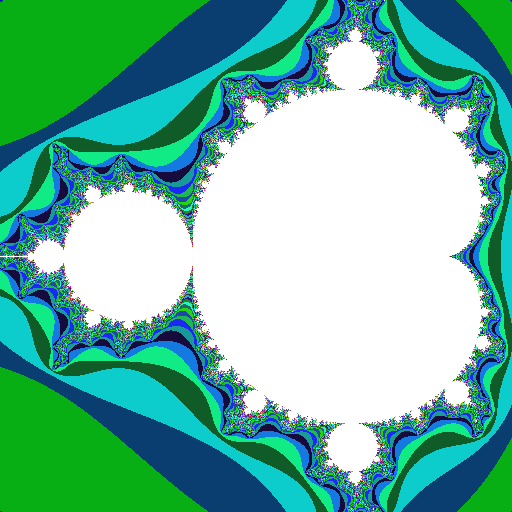